# Sine Wave Predictor

This notebook is a very simple recurrent neural net using tensorflow to predict the next value/values of a sine wave

In [1]:
# Import dependancies
import tensorflow as tf                    # our machine learning library
import numpy as np                         # our python library for dealing with arrays
import matplotlib.pyplot as plt, pylab     # our graphing library
import time                                # for pauses when updating graphs

# this is to present our graph interactively 
% matplotlib notebook

In [2]:
# gpu options, 90% of gpu memory assigned to this python kernel
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# set the size of the state
state_size = 4
# set the number of lines to learn in parallel
# in this case we are just looking at one sine wave 
batch_size = 1

# training parameters
iterations = 2000
learning_rate = 0.1

# number of steps to predict into the future
steps_to_predict = 30

# number of previous points to be inputted, must be >= steps_to_predict
truncated_backprop_length = 30

# total size of training data series
# this calculation will return an array the exact size required
total_series_length = iterations+truncated_backprop_length+steps_to_predict

In [3]:
# function to generate training data
def generate_data(length):
    
    # create x data for line with max value of length
    # it increases by 0.1 each step
    x = np.linspace(0,length, length*10+1)
    
    # create y data for line by applying numpy's sin function to x data
    # we reshape so that each time step is in a new layer/page
    # the rows are the batch size and the columns are the features
    y = np.sin(x).reshape(-1,batch_size,1)
    
    # return the y data
    return(y)

In [4]:
# function to update plot
def plot_data(X_data,X2_data,Y_data, pred_data, sleep_time):
  
    # plot real line
    ax.plot(X_data,Y_data, 'g')
    # plot predicted line
    ax.plot(X2_data,pred_data, '--r')
    fig.canvas.draw()
    # pause for specified amount of time
    time.sleep(sleep_time)

In [5]:
# function to update plot during training
def training_plot(_new_values, pred_training,save):

    # set the X data for both the prediciton and label's line
    X_training = np.linspace(0, pred_training.size/10., pred_training.size)
    
    # update the real line's data fro plotting
    Y_training = x_data[0:pred_training.size].reshape(-1)
        
    # set max and min for the X axis so it moves along the graph with the prediction line
    if X_training.size > 200:
        xmin = X_training[-200]
    else:
        xmin= 0
    xmax = X_training[-1]
    ax.set_xlim(xmin, xmax)
    # set the y axis limits
    ax.set_ylim(-1.2,1.2)
        
    # update the plot on the graph
    plot_data(X_training,X_training,Y_training, pred_training, 0)
            
    # plot the loss on the second figure
    ax2.grid(True)
    ax2.plot(training_loss)
    fig2.canvas.draw()
        
    # save the images of the graphs if requested to
    if save == True:
        fig.savefig('training_graphs/training_graph_step_%s.png' % start_index )        # prediction graphs
        fig2.savefig('training_graphs/training_loss_graph_step_%s.png' % start_index )  # loss graphs

    # return the updated prediction array
    return(pred_training)

<IPython.core.display.Javascript object>


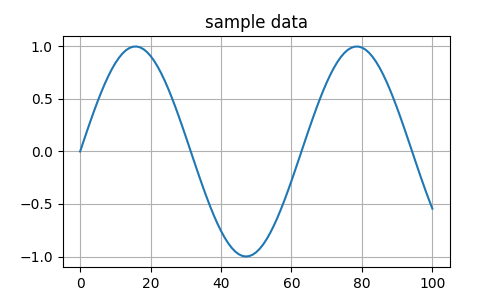

In [6]:
# plot example data
# generate data going up to 10, in 101 steps
line_data = generate_data(10)
fig, ax = plt.subplots(figsize=(5,3))
# plot data but reshape to a 1d array
ax.plot(line_data.reshape(-1))
ax.grid(True)
plt.title('sample data')
# show plot
plt.show()

In [7]:
# create placeholders for input data and labels
# we are inputting a set of points with an unknown time steps size, but with fixed batch size and features 
# the labels are the values next in the series with size of steps_to_predict
batchX_placeholder = tf.placeholder(tf.float32, [None, batch_size, 1])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, steps_to_predict])

# create an initial state placeholder
init_state = tf.placeholder(dtype=tf.float32, shape=[batch_size, state_size])

# create Weights and a bias for the connected layer from the output of the RNN cell
W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

# split the labels into different arrays for each time step
labels_series = tf.split(axis=1, num_or_size_splits=steps_to_predict, value=batchY_placeholder)

# set the inputs series to the input array placeholder
inputs_series = batchX_placeholder

In [8]:
# create RNN cell using tensorflows BasicRNNCell function with number of units as state_size
cell = tf.contrib.rnn.core_rnn_cell.BasicRNNCell(num_units=state_size)

# we are using the dynamic rnn function to call the RNN cell
# we set the new output series and and the updated current state
# we input the RNN cell from above, the input series data adn  use the initial state which is the current state for this prediction
# time_major = True means that the input data will be in shape [time_steps, batch_size, features] instead of [batch_size, time_steps, features]
states_series, current_state = tf.nn.dynamic_rnn(cell, inputs_series, initial_state=init_state, time_major=True)

In [9]:
# initialize the logits series as an empty array
logits_series = []

# for each outputed set of values, we apply the second weights and biases
for i in range(steps_to_predict):
  
    # first, we apply the weights and biases for the fully connected layer
    # we then append the predicted value for this time step to the logits_series list
    logits_series.append(tf.reshape((tf.matmul(states_series[-(steps_to_predict-i)], W2) + b2), shape=[1]))

# calculate loss using l2 loss as it is using continuous data and not classes
# again repeat this for each value in the logits series
losses = [tf.nn.l2_loss(label - logit, name=None) for logit, label in zip(logits_series, labels_series)]

# average the loss for all values predicted
total_loss = tf.reduce_mean(losses)

# we are using Adagrad optimizer, we can use adam, but for one function it's unnecessary
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

# generate training data
x_data = generate_data(total_series_length)

# initialize a current state with zeros
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

<IPython.core.display.Javascript object>


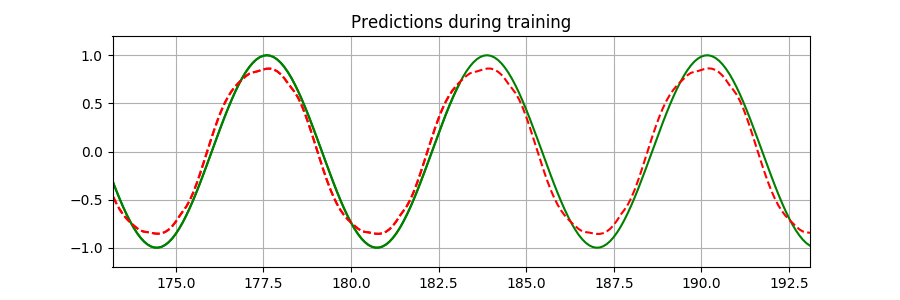

<IPython.core.display.Javascript object>


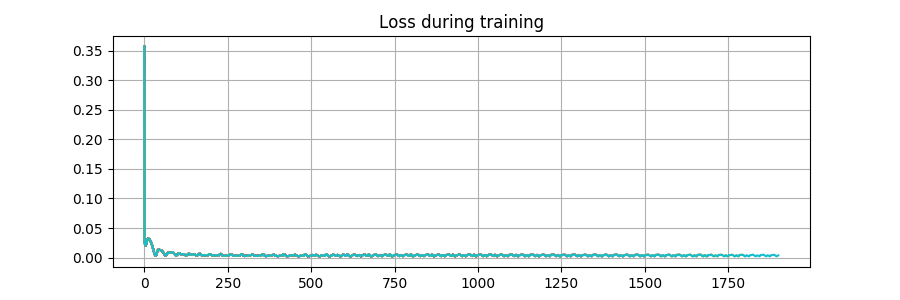

Step 0 Loss = 0.356797
Step 100 Loss = 0.00562106
Step 200 Loss = 0.00511354
Step 300 Loss = 0.00266689
Step 400 Loss = 0.00257948
Step 500 Loss = 0.00383217
Step 600 Loss = 0.00424734
Step 700 Loss = 0.00275228
Step 800 Loss = 0.00516499
Step 900 Loss = 0.0025111
Step 1000 Loss = 0.00411664
Step 1100 Loss = 0.00521927
Step 1200 Loss = 0.00387328
Step 1300 Loss = 0.00325587
Step 1400 Loss = 0.00321244
Step 1500 Loss = 0.0038802
Step 1600 Loss = 0.004783
Step 1700 Loss = 0.00465571
Step 1800 Loss = 0.0022296
Step 1900 Loss = 0.00378104
Done Training


In [16]:
# start session and initialize variables
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())


# set up variables for plotting during training

# initiate real line and X data for predicted line as empty arrays
Y_training = X_training = np.array([])

# the predictions will not predict the first points in the sequence as there is no previous data
# so we set the first points to the real lines data
pred_training = x_data[0:truncated_backprop_length]

# setup subplot which we'll update during the training loop
fig,ax = plt.subplots(1,1, figsize=(9,3))
fig2,ax2 = plt.subplots(1,1, figsize=(9,3))
ax.set_title('Predictions during training')
ax2.set_title('Loss during training')
ax.grid(True)
ax2.grid(True)
training_loss = np.array([])


# start training loop
# start_index is going to be the index for the first value of the input data in the current iteration
for start_index in range(iterations):

    # set the end index to the index of the last value in the input data of this iteration
    end_index = start_index + truncated_backprop_length

    # select input data and labels for current batch
    
    # the input data is selected using the start and end index
    batchX = x_data[start_index:end_index,:,:]
    
    # the labels data is selected from the end of the input data to steps_to_predict number of time steps ahead
    batchY = x_data[end_index:end_index+steps_to_predict,:,:].reshape(1,-1)

    # run the training step feeding in the selected data and the current state
    # return the total_loss to print
    # return the train_step to run the optimizer
    # return the current state to update it to the next state
    # return the logits_series to plot on our graph
    _total_loss, _train_step, _current_state, _new_values = sess.run([total_loss, train_step, current_state, logits_series],
        feed_dict={
            batchX_placeholder:batchX,
            batchY_placeholder:batchY,
            init_state:_current_state
        })
    
    # print the index and loss 20 times in total
    if (start_index)%(iterations/20) == 0:
        print 'Step',start_index, 'Loss =', _total_loss
                
    # set new_values to the first predicted point
    # we dont use the whole prediction as we will plot those points in the next iterations
    # this plot is just to get an idea of how its training
    _new_values = np.array(_new_values[0])
    
    # update prediction and loss array to plot
    pred_training = np.append(pred_training, _new_values)
    training_loss = np.append(training_loss, _total_loss)

    # plot the new data every certain nummber of steps
    if (start_index)%(100) == 0:
        # call the training plot function to plot graphs and update our prediction array
        pred_training = training_plot(_new_values, pred_training, False)

# print when training has finished
print 'Done Training'

<IPython.core.display.Javascript object>


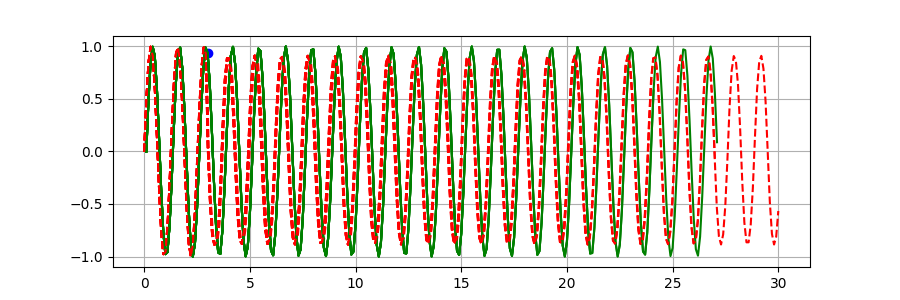

<IPython.core.display.Javascript object>


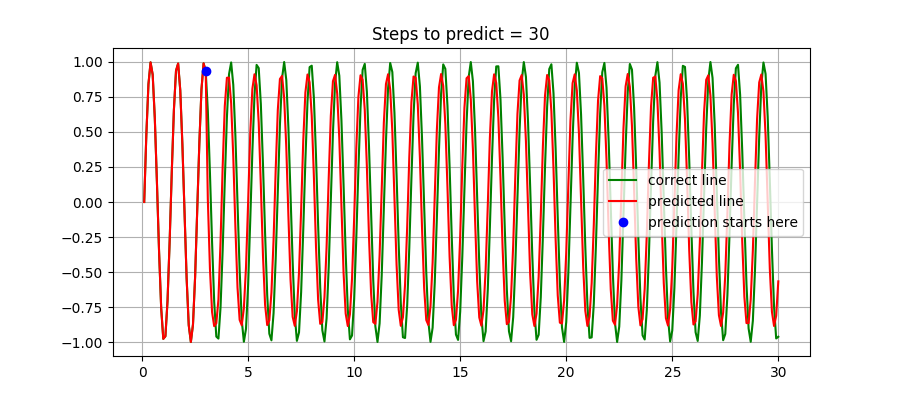

In [35]:
# Test our model

# initialize pred, Y and X arrays as empty
pred = Y = X = np.array([])

# initialize current state for testing
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

# this will be our x values 
n = 0

# setup subplot which we'll update during the loop
fig,ax = plt.subplots(1,1, figsize=(9,3))
ax.grid(True)

# loop for 300 steps
for i in range(300):
    
    # Y will be the correct line so we will apply the sin function to it
    Y = np.append(Y, np.sin(n)).reshape(1,-1)
    
    # increase the steps by 0.1
    n += 0.1
    # append X array with current step
    X = np.append(X, n)
    
    
    # if we haven't got enough points to use as input data
    # dont run the prediction and instead use the real points as the prediction line instead
    if i < truncated_backprop_length:
        # append the real line data point/points
        pred = np.append(pred, Y[:,-1])
        
        # update the graph at the same rate as if it was predicting
        if i % steps_to_predict == 0:
            
            # plot the graph using X as our prediction X data
            plot_data(X,X,Y.reshape(-1),pred, 0.1)
            
            
    # plot a blue dot where it starts making predictions
    if i == (truncated_backprop_length-1):
        ax.plot(X[-1],pred[-1], 'bo')
        fig.canvas.draw()
        time.sleep(0.1)

        
    # when we have enough previous points to use as input data, run the prediction
    # run only when the real data has almost caught up with the predicted data
    elif i >= truncated_backprop_length and (i-truncated_backprop_length) % steps_to_predict == 0:
        
        # set previous, our input data, to the last truncated_backprop_length number of points from the real line
        previous = np.array(Y[:,-(truncated_backprop_length+1):-1]).reshape(-1,1,1)
        
        # predict the new values and set the new current state
        # it runs the  output series and only picks the points that have been predicted
        # it ignores the values which were also in the input
        new_values, _current_state = sess.run(
                [logits_series[-(steps_to_predict):truncated_backprop_length], current_state],
                feed_dict={
                    batchX_placeholder:previous,   # input previous
                    init_state:_current_state      # use current state as state
                })

        # append to pred with the predicted value/values
        pred = np.append(pred, new_values)
        
        # X2 is our X values but the same size as pred so we can plot pred before the Y values reach it 
        X2 = np.linspace(0, pred.size/10., pred.size)
        
        # plot the graph using X2 as our prediction X data
        plot_data(X,X2,Y.reshape(-1),pred, 0.1)
        

# set up final plot
plt.figure(figsize=(9,4))
plt.subplot()
plt.grid(True)
plt.title('Steps to predict = %i' % steps_to_predict)

# sometimes, the predictions go beyond the real line so we cut them off
pred = pred[0:Y.size]

# plot the correct line, Y
plt.plot(X,Y[0], 'g', label='correct line')
# plot the predicted line
plt.plot(X,pred, 'r', label='predicted line')
# plot the point where the prediction starts
plt.plot(X[truncated_backprop_length-1], pred[truncated_backprop_length-1], 'bo', label='prediction starts here')

# show the labels
plt.legend()
# set the axis size to 110% the max 
pylab.ylim([-1.1*np.max(np.abs(np.vstack((Y,pred)))),1.1*np.max(np.abs(np.vstack((Y,pred))))])
plt.grid(True)
# show the plot
plt.show()